# Customer Segmentation



### Machine Learning II Project

   - Bruno Moreira            | 20211574@novaims.unl.pt
   - Carolina Braziel Shaul   | 20211557@novaims.unl.pt
   - Madalena Dias Frango     | 20211522@novaims.unl.pt

## Table of Contents

<br>
[2.4. Data Adjustments](#2.4.-bullet)<br>
<br>
[2.5. K-Means](#2.5.-bullet)<br>
<br>
[2.5.1. Solution 1](#2.5.1.-bullet)<br>
<br>
[2.5.2. Solution 2](#2.5.2.-bullet)<br>
<br>
[2.5.3. Solution 3](#2.5.3.-bullet)<br>

<br>

---
<br>

<br>

---
<br>

<a class="anchor" id="1-bullet">     
    

### 1. Importing Data & Libraries 

</a>


In [1]:
#Basic Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import confusion_matrix
import squarify

#To find addresses
import reverse_geocoder as rg
from geopy.geocoders import Nominatim

#Plot Maps
import folium
from folium.plugins import HeatMap, MarkerCluster 

#Functions
import Functions

%load_ext autoreload
%autoreload 2

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
individuals = pd.read_csv('clientes_preprocessed.csv')
transactions = pd.read_csv('Customer Basket Dataset.csv')
prod_mapping = pd.read_excel('Product Mapping Excel File.xlsx')

In [3]:
individuals.set_index('customer_id', inplace=True)

In [4]:
individuals.columns

Index(['customer_name', 'customer_gender', 'kids_home', 'teens_home',
       'number_complaints', 'distinct_stores_visited',
       'lifetime_spend_groceries', 'lifetime_spend_electronics',
       'typical_hour', 'lifetime_spend_vegetables',
       'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks',
       'lifetime_spend_meat', 'lifetime_spend_fish', 'lifetime_spend_hygiene',
       'lifetime_spend_videogames', 'lifetime_total_distinct_products',
       'percentage_of_products_bought_promotion', 'year_first_transaction',
       'loyalty_card', 'region', 'latitude_encoded', 'longitude_encoded',
       'total_lifetime_spend', 'minors_in_household', 'birthday', 'birthmonth',
       'age', 'education'],
      dtype='object')

<br>

---
<br>

<a class="anchor" id="2.4.-bullet">     
    

### 2.4. Data Adjustments

</a>

#### Joining Features

In [5]:
individuals['lifetime_spend_animal_protein'] = individuals[['lifetime_spend_fish', 'lifetime_spend_meat']].sum(axis=1)
individuals['lifetime_spend_technology'] = individuals[['lifetime_spend_videogames', 'lifetime_spend_electronics']].sum(axis=1)

In [6]:
corr_matrix = individuals.drop(['lifetime_spend_fish', 'lifetime_spend_meat', 'lifetime_spend_videogames', 'lifetime_spend_electronics'], axis = 1).corr()
Functions.get_high_correlations(corr_matrix, 0.66)

,Variable 1,Variable 2,Correlation
10,lifetime_total_distinct_products,lifetime_spend_animal_protein,0.932928
3,lifetime_spend_groceries,lifetime_total_distinct_products,0.926119
2,distinct_stores_visited,percentage_of_products_bought_promotion,0.923021
6,lifetime_spend_groceries,lifetime_spend_animal_protein,0.915666
5,lifetime_spend_groceries,total_lifetime_spend,0.913175
0,kids_home,minors_in_household,0.895671
11,total_lifetime_spend,lifetime_spend_animal_protein,0.872337
9,lifetime_total_distinct_products,total_lifetime_spend,0.855891
1,teens_home,minors_in_household,0.799848
7,lifetime_spend_nonalcohol_drinks,lifetime_spend_technology,0.787628


In [7]:
continuous = ['lifetime_spend_groceries', 'lifetime_spend_electronics', 'lifetime_spend_vegetables',
       'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks',
       'lifetime_spend_meat', 'lifetime_spend_fish', 'lifetime_spend_hygiene',
       'lifetime_spend_videogames', 'lifetime_total_distinct_products',
       'percentage_of_products_bought_promotion', 'year_first_transaction', 'total_lifetime_spend', 'age', 'birthday' ]

#Variaveis tais como 'lifetime_total_distinct_products', 'year_first_transaction', 
#  'age', 'birthday', estão a ser tratadas como continuas neste contexto dada a amplitude delas.

discrete = ['kids_home', 'teens_home', 'typical_hour', 'birthmonth',
       'number_complaints', 'distinct_stores_visited', 'minors_in_household', 'education']

binary = ['customer_gender', 'loyalty_card']

#### Scalling

In [8]:
scaler = MinMaxScaler()
individuals_num = individuals.drop(['customer_name', 'region'], axis=1)
scaled_data = scaler.fit_transform(individuals_num)
scaled_data = pd.DataFrame(scaled_data, index= individuals_num.index, columns=individuals_num.columns)

<a class="anchor" id="2.5.-bullet">     
    

### 2.5. K-Means

</a>

 Variavel "columns" são as variaveis a plottar no pairplot

In [9]:
columns = ['lifetime_spend_groceries', 'lifetime_spend_electronics', 'lifetime_spend_vegetables',
 'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks', 'lifetime_spend_hygiene',
 'lifetime_spend_videogames', 'lifetime_total_distinct_products', 'percentage_of_products_bought_promotion',
 'year_first_transaction', 'total_lifetime_spend', 'age', 'kids_home', 'teens_home',
 'typical_hour', 'number_complaints','distinct_stores_visited', 'minors_in_household']

In [10]:
colors = ['#F29687','#5D64AC','#EFD56C','#B5699C','#569F6E']

<a class="anchor" id="2.5.3.-bullet">     
    

#### 2.5.3. Solution 3
</a>

Esta solução é caracterizada por utilizar as seguintes variaveis para segmentação em SEIS (6) clusters:

> 'customer_gender', 'kids_home', 'teens_home', 'number_complaints',
       'distinct_stores_visited', 'lifetime_spend_groceries', 'typical_hour',
       'lifetime_spend_vegetables', 'lifetime_spend_nonalcohol_drinks',
       'lifetime_spend_alcohol_drinks', 'lifetime_spend_hygiene',
       'lifetime_total_distinct_products',
       'percentage_of_products_bought_promotion', 'year_first_transaction',
       'loyalty_card', 'latitude_encoded', 'longitude_encoded',
       'total_lifetime_spend', 'minors_in_household', 'age', 'education',
       'lifetime_spend_animal_protein', 'lifetime_spend_technology'

In [11]:
fit_variables = ['customer_gender', 'kids_home', 'teens_home', 'number_complaints',
       'distinct_stores_visited', 'lifetime_spend_groceries', 'typical_hour',
       'lifetime_spend_vegetables', 'lifetime_spend_nonalcohol_drinks',
       'lifetime_spend_alcohol_drinks', 'lifetime_spend_hygiene',
       'lifetime_total_distinct_products',
       'percentage_of_products_bought_promotion', 'year_first_transaction',
       'loyalty_card', 'latitude_encoded', 'longitude_encoded',
       'total_lifetime_spend', 'minors_in_household', 'age', 'education',
       'lifetime_spend_animal_protein', 'lifetime_spend_technology']

##### Fitting the Model

In [12]:
kmeans_sol3 = KMeans(n_clusters=6, random_state=0).fit(scaled_data[fit_variables])
individuals['cluster_kmeans3'] =  kmeans_sol3.predict(scaled_data[fit_variables])

##### Analyzing the Results

In [13]:
individuals.groupby('cluster_kmeans3')['customer_gender'].count()

cluster_kmeans3
0    5173
1    4740
2    4610
3    4714
4    5616
5    4921
Name: customer_gender, dtype: int64

In [14]:
Functions.compare_clusters(individuals, 'cluster_kmeans3')

,0,1,2,3,4,5,general_mean
customer_gender,0.506089,0.489873,0.494143,0.496818,0.499644,0.491567,0.496574
kids_home,2.303886,1.158228,0.689588,1.542639,0.288462,1.000203,1.155404
teens_home,1.236227,0.770886,0.068547,0.711922,0.235577,0.069904,0.516827
number_complaints,1.159482,0.311181,0.500000,1.221468,0.431268,1.010567,0.770169
distinct_stores_visited,4.849990,2.000000,1.992625,6.031396,2.275819,20.001829,6.159636
lifetime_spend_groceries,8674.426445,996.438397,200.406291,11255.840899,2544.109509,302.959764,4008.813629
lifetime_spend_electronics,200.217089,51.616667,4999.557484,276.637251,574.442664,20.000000,972.556727
typical_hour,15.418713,9.963080,20.951844,14.179678,17.076211,8.991668,14.461107
lifetime_spend_vegetables,674.933501,1495.472363,20.033623,702.553458,260.710826,300.231863,568.474340
lifetime_spend_nonalcohol_drinks,901.736323,20.935232,1500.946855,851.244166,300.483262,300.431823,633.505206


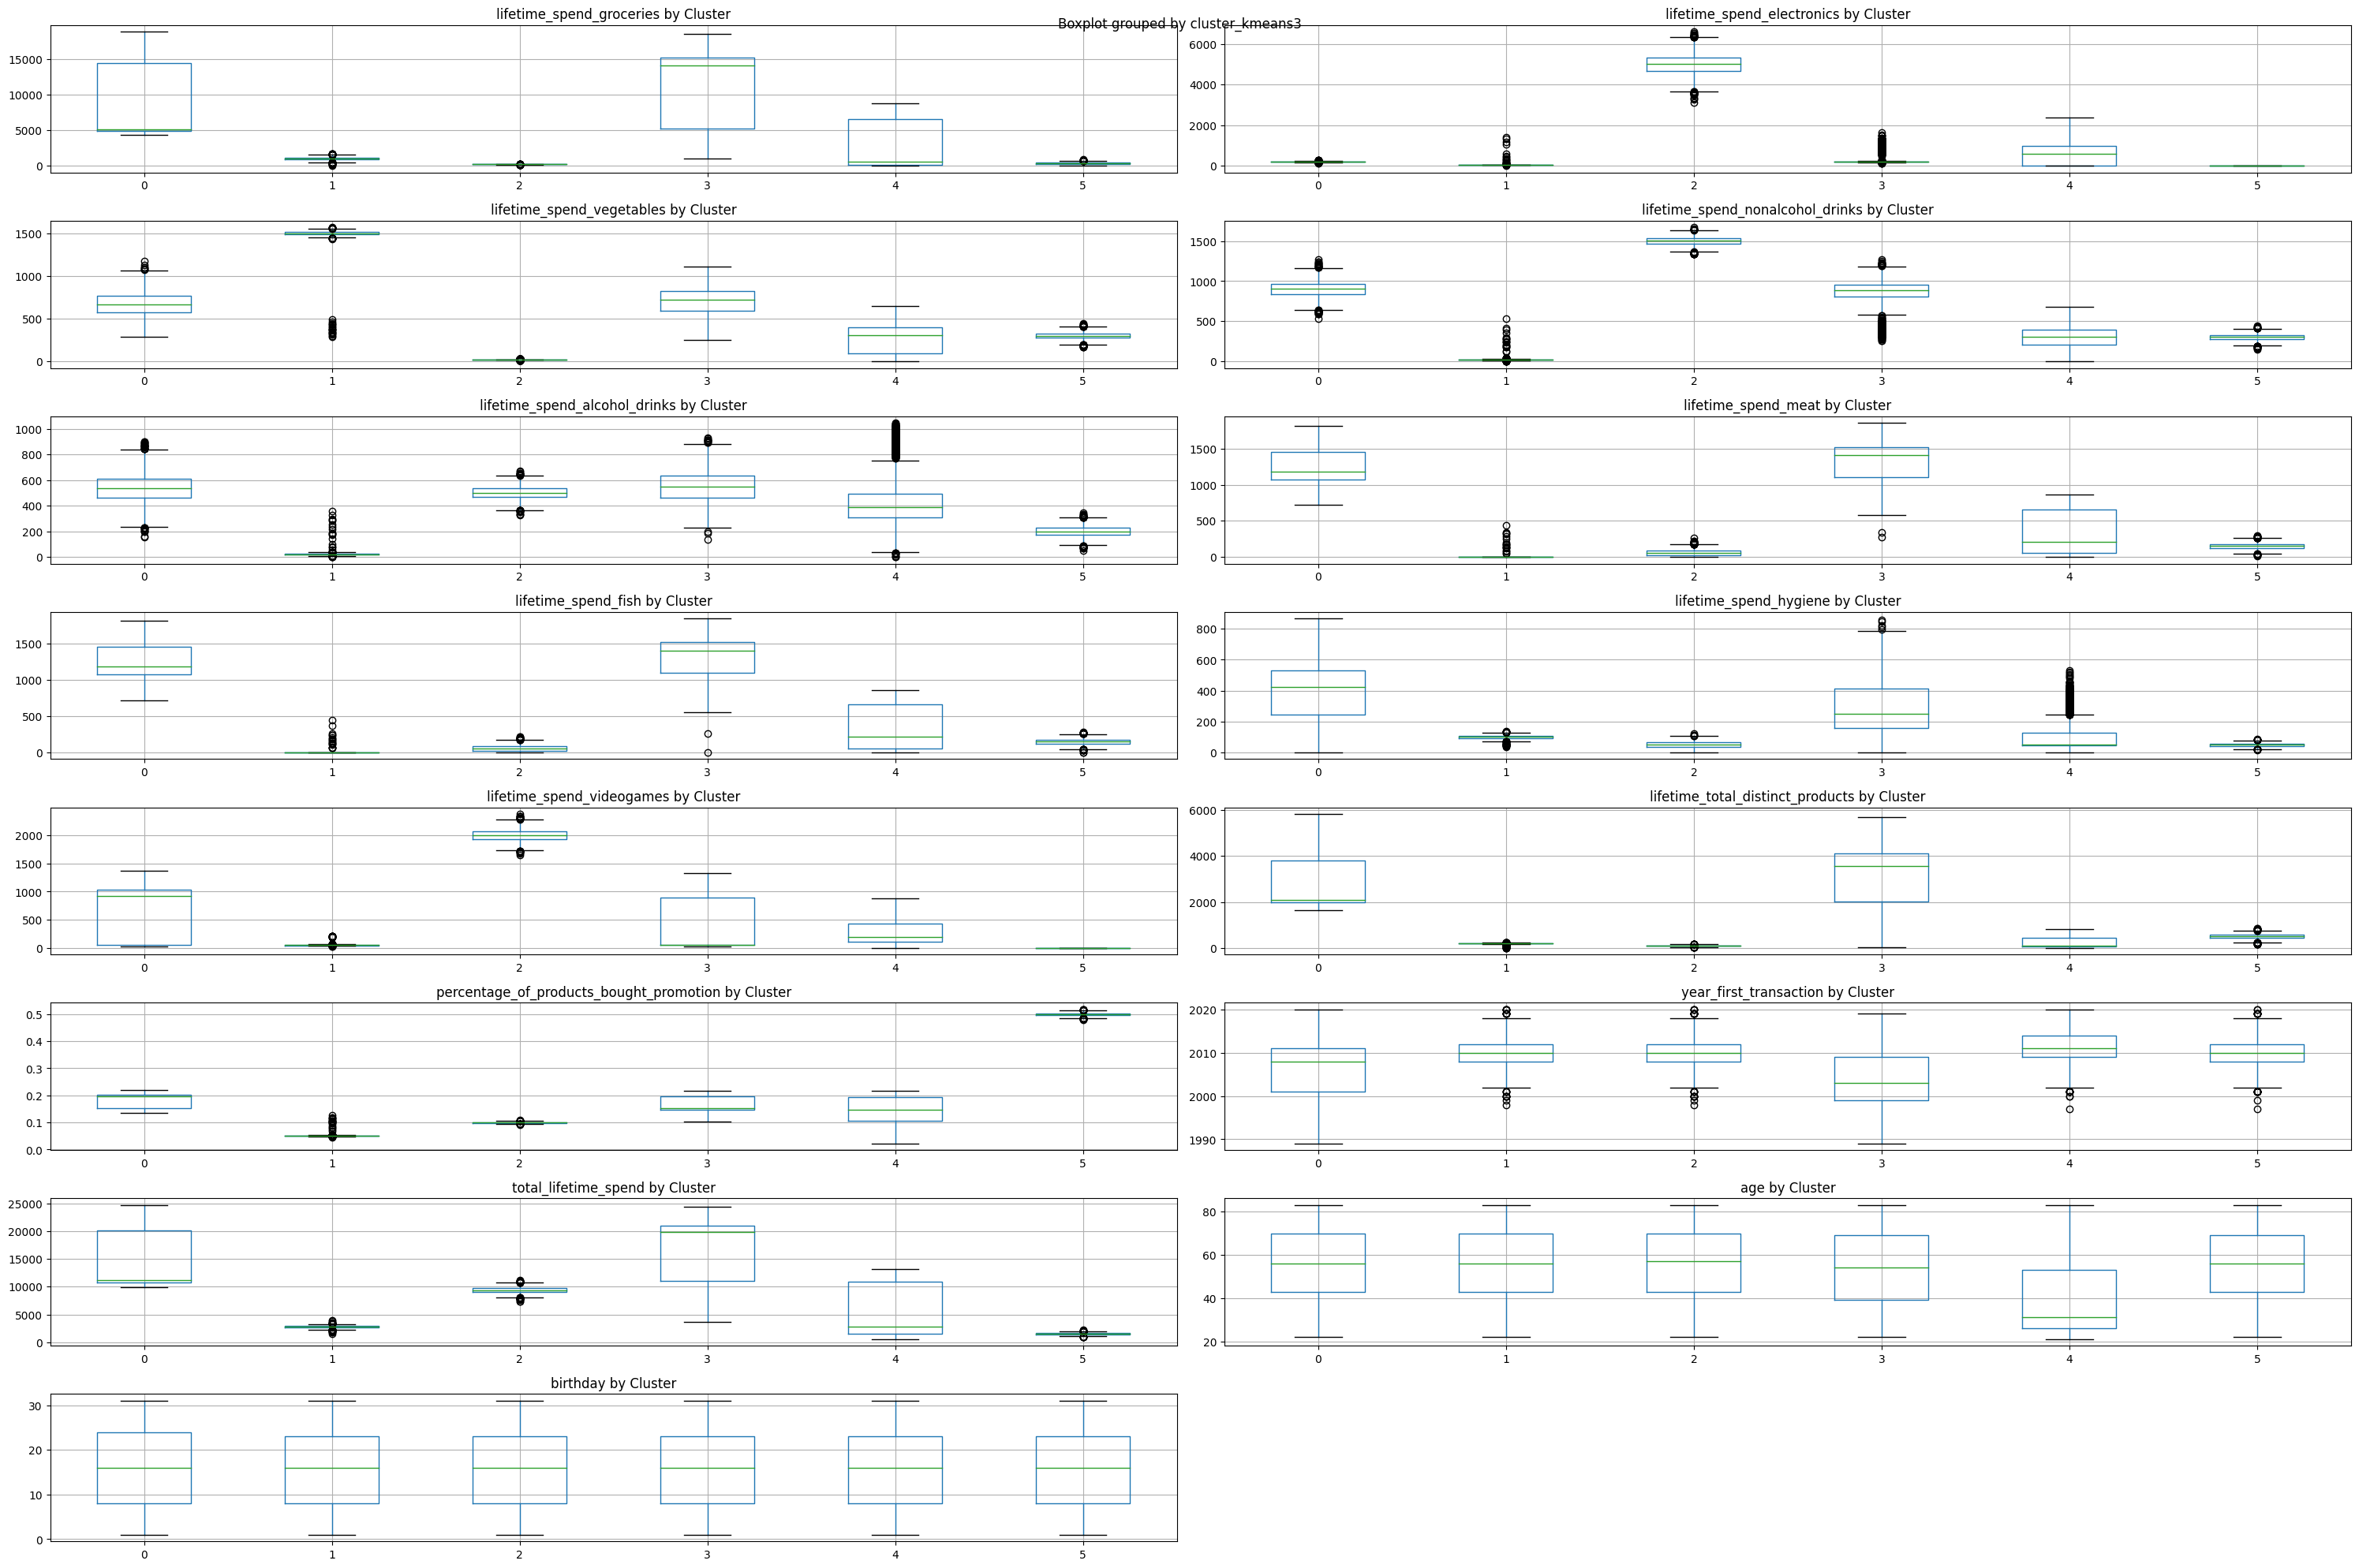

In [15]:
fig, axs = plt.subplots(12, 2, figsize=(30, 30))

    # Flatten the axs array for easy indexing
axs = axs.flatten()

for i, column in enumerate(continuous):
    ax = axs[i]
    individuals.boxplot(column=column, by='cluster_kmeans3', ax=ax)
    ax.set_xlabel('')
    ax.set_title(column + ' by Cluster')

for i in range(len(axs)):
    if i >= len(continuous):
        axs[i].set_visible(False)

    # Adjust spacing between subplots
fig.tight_layout()

    # Show the plot
plt.show()

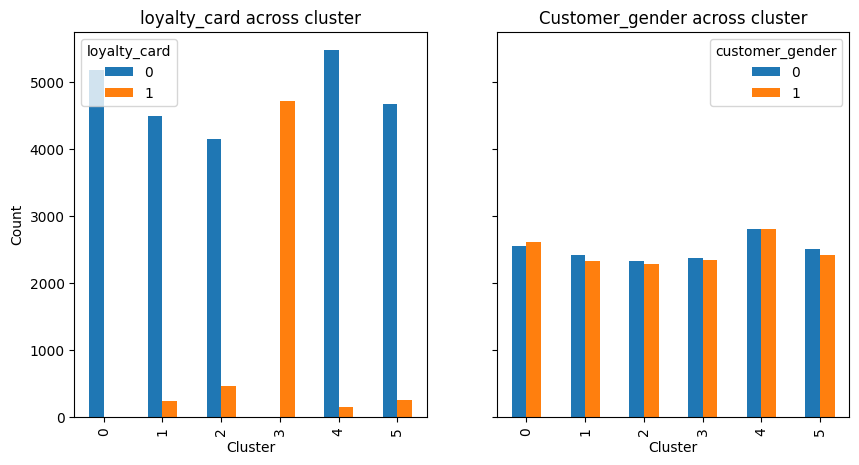

In [16]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

individuals.groupby('cluster_kmeans3')['loyalty_card'].value_counts().unstack().plot(kind='bar', ax=axs[0])

# Set axis labels and title for the first subplot
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Count')
axs[0].set_title('loyalty_card across cluster')

individuals.groupby('cluster_kmeans3')['customer_gender'].value_counts().unstack().plot(kind='bar', ax=axs[1])

# Set axis labels and title for the second subplot
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Count')
axs[1].set_title('Customer_gender across cluster')

# Show the plot
plt.show()

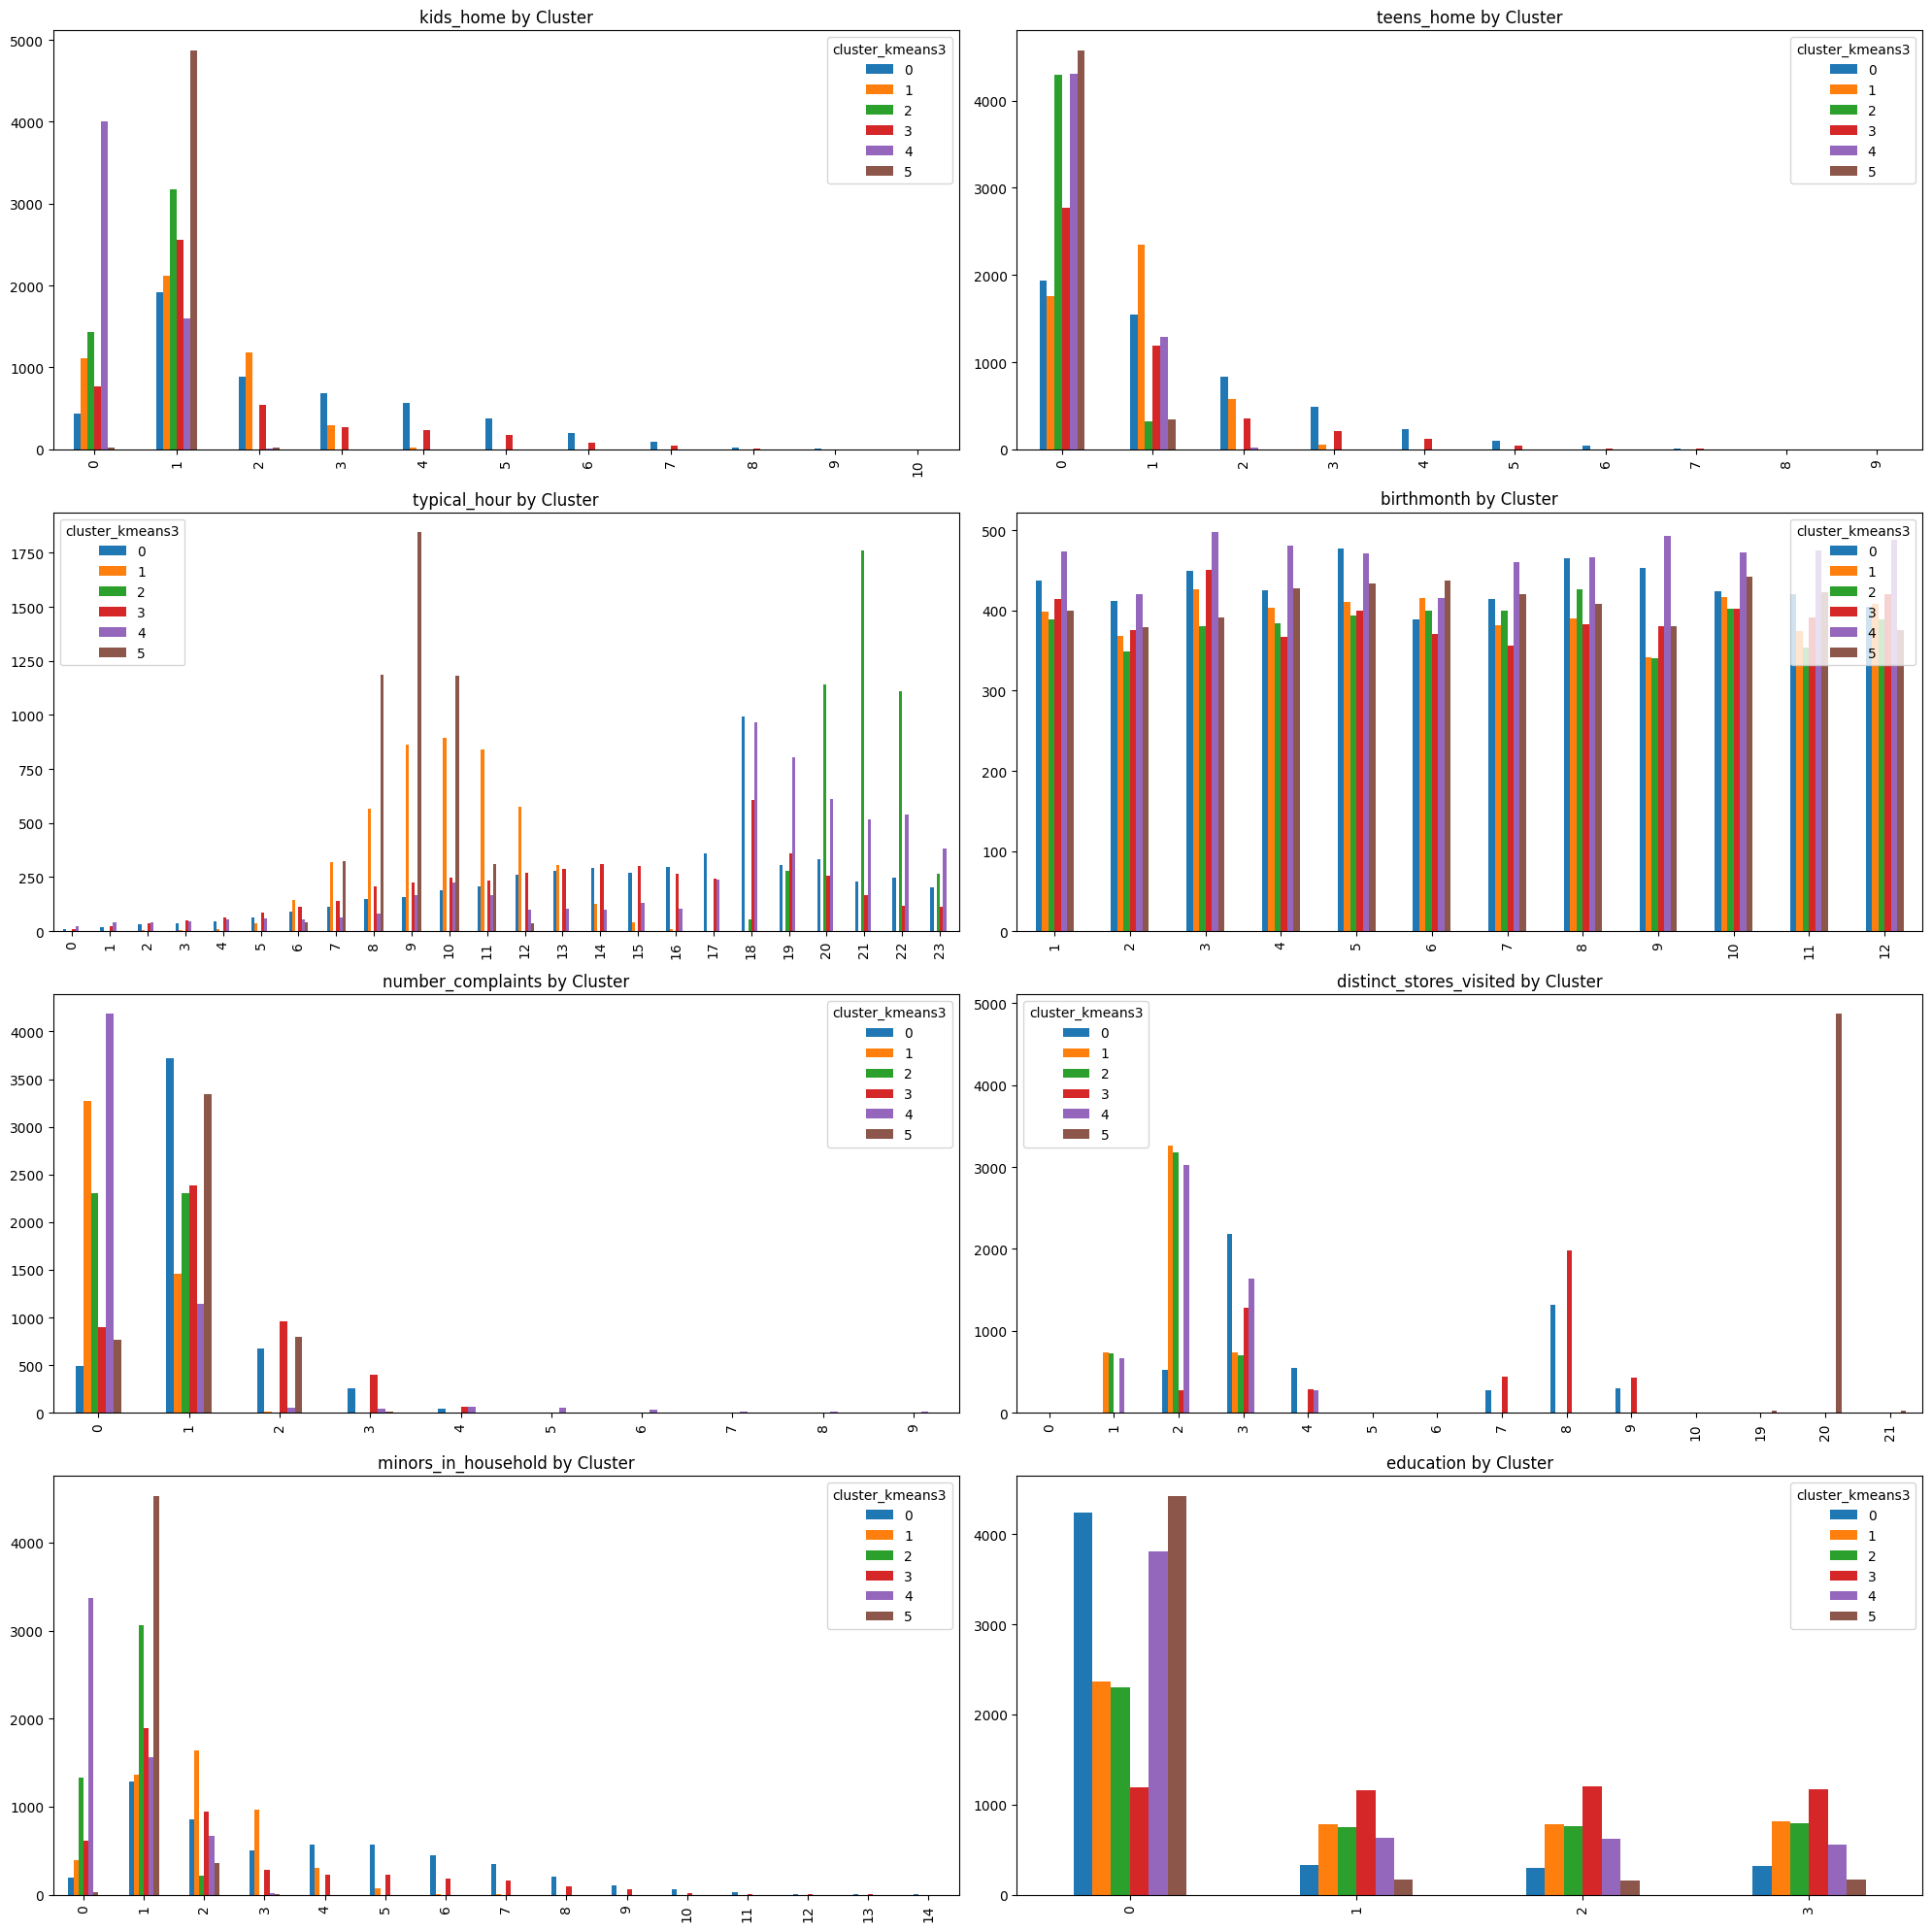

In [17]:
#HELP!!! PRECISO DE UMA ALTERNATIVA A ESTE PESSIMO GRAFICO
fig, axs = plt.subplots(4, 2, figsize=(20, 20))

    # Flatten the axs array for easy indexing
axs = axs.flatten()

for i, column in enumerate(discrete):
    ax = axs[i]
    individuals.groupby(column)['cluster_kmeans3'].value_counts().unstack().plot(kind='bar', ax=ax)
    ax.set_xlabel('')
    ax.set_title(column + ' by Cluster')

for i in range(len(axs)):
    if i >= len(discrete):
        axs[i].set_visible(False)

    # Adjust spacing between subplots
fig.tight_layout()

    # Show the plot
plt.show()

In [18]:
colors = ['#F29687','#5D64AC','#EFD56C','#B5699C','#569F6E', '#1C003B']

KeyError: 'cluster_kmeans3'

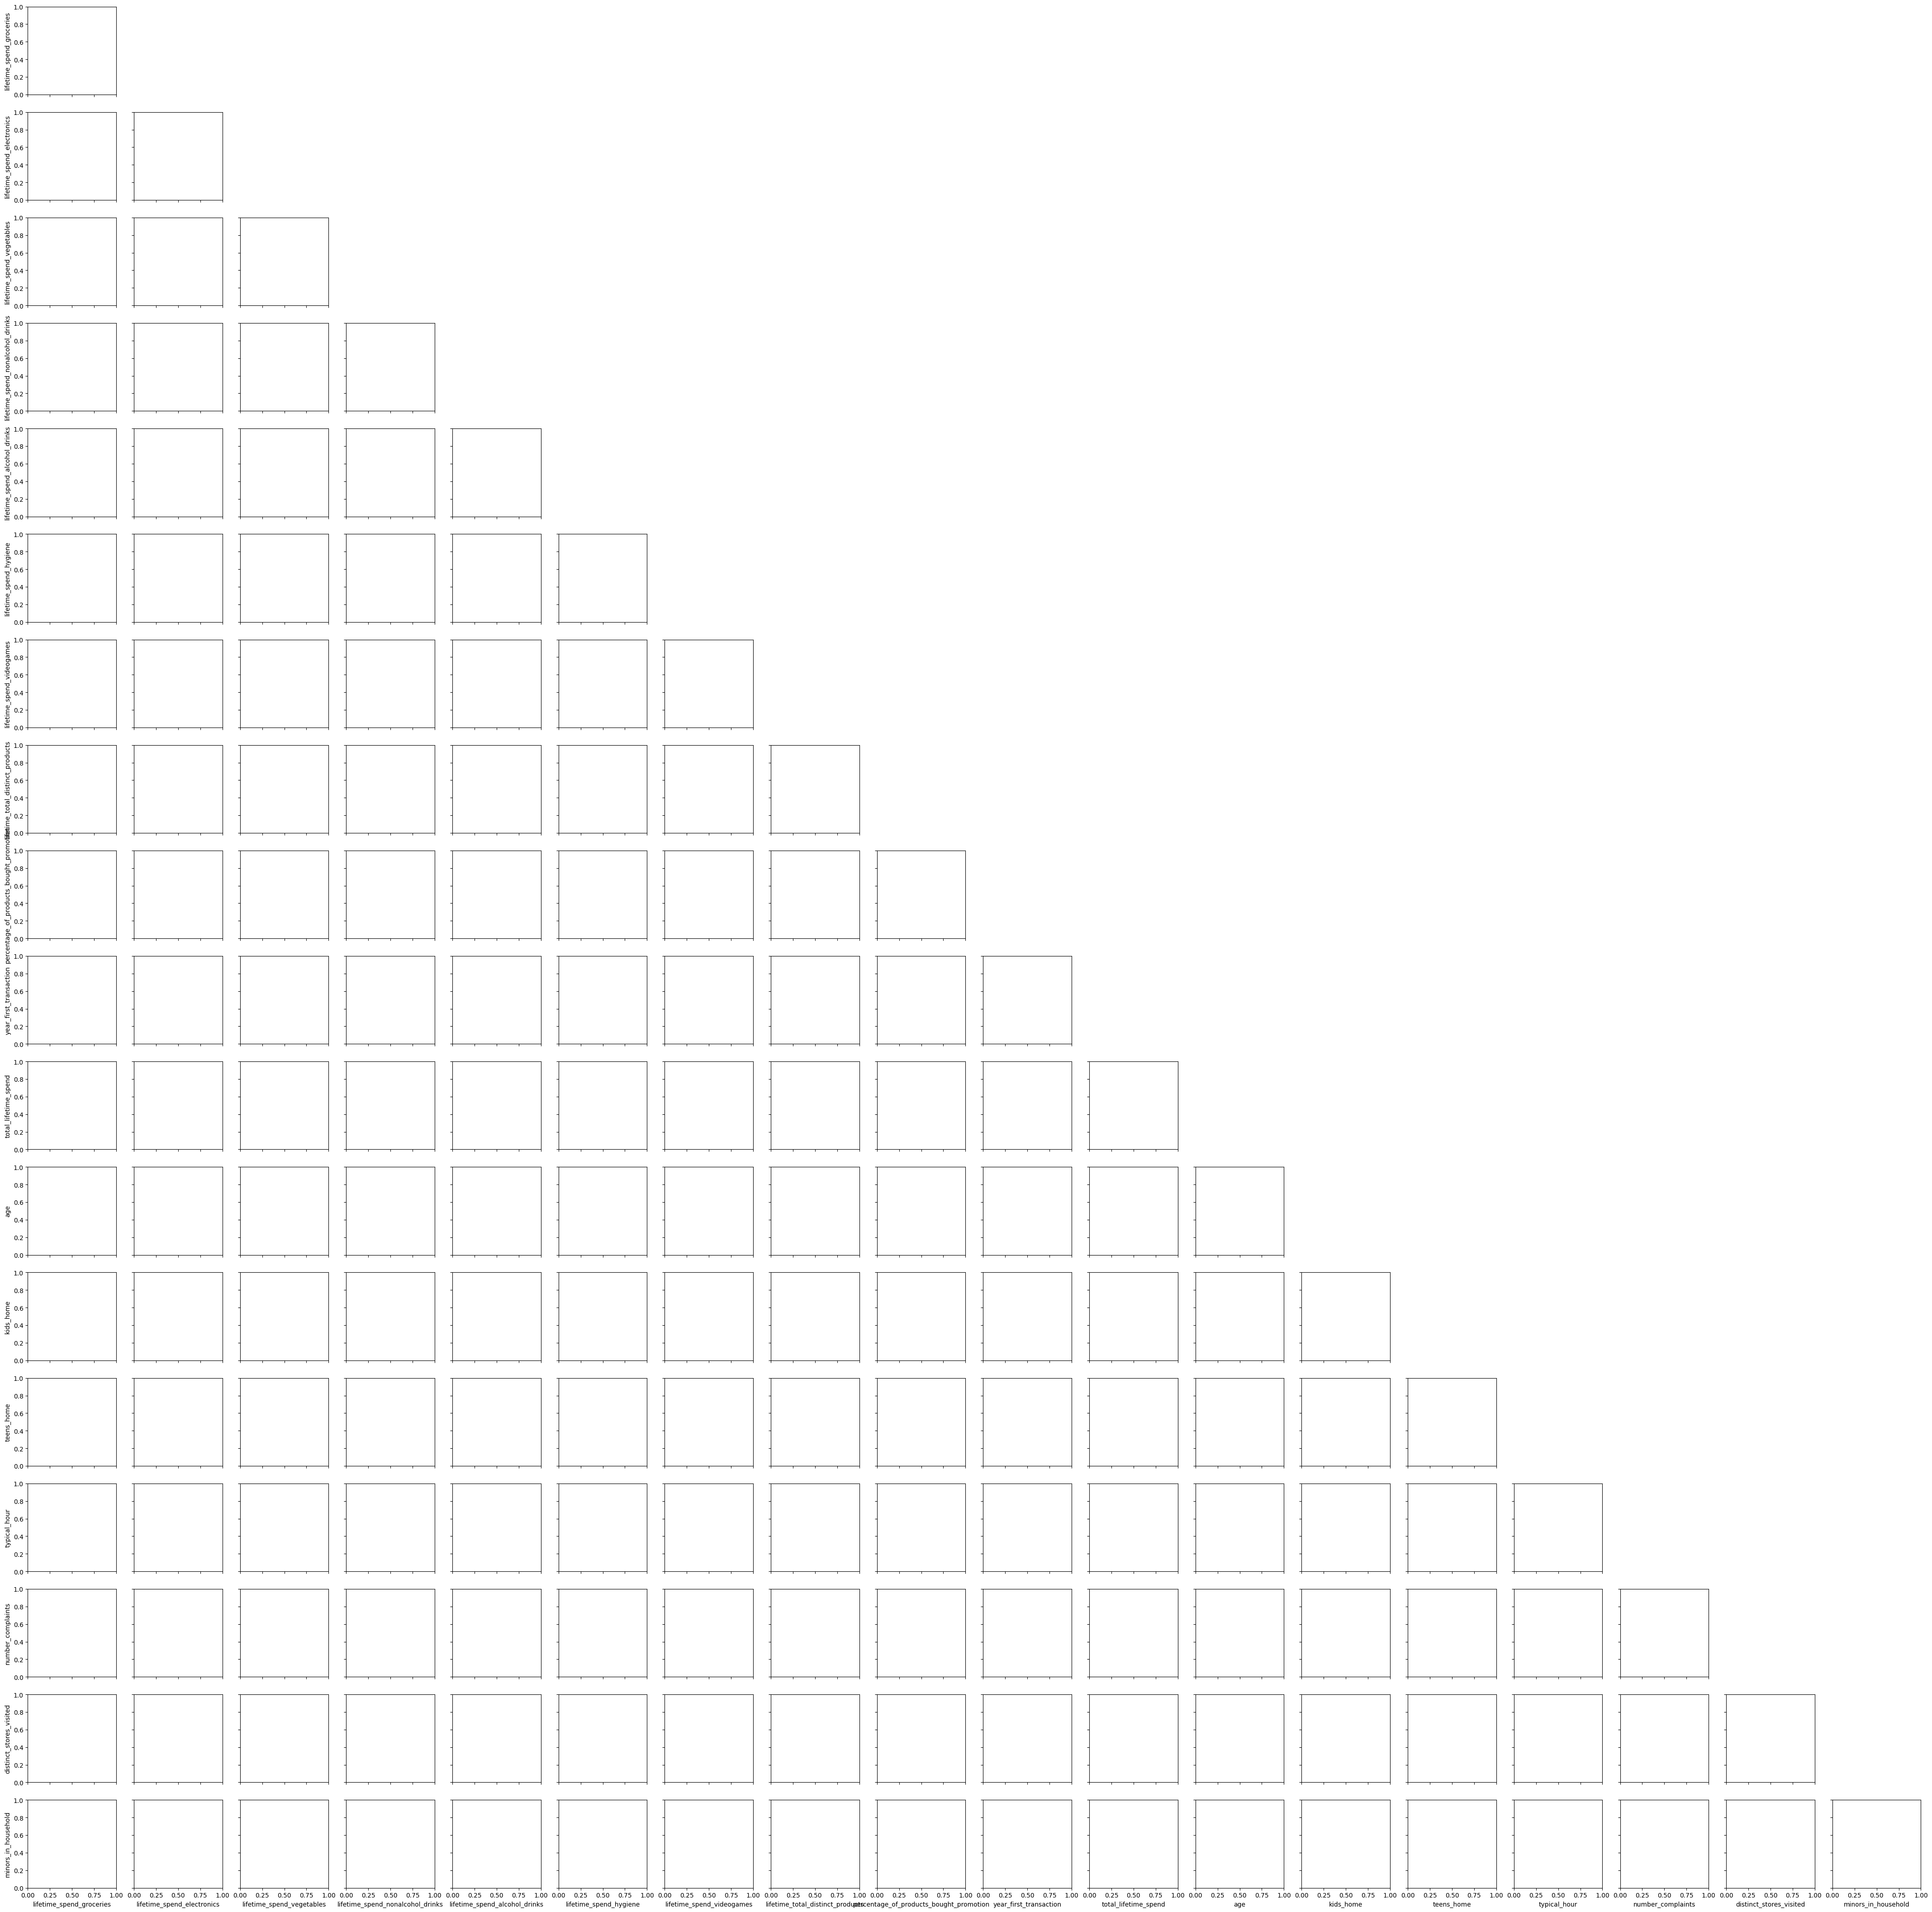

In [19]:
sns.pairplot(individuals[columns], hue = "cluster_kmeans3", kind = 'scatter', diag_kind = 'hist', corner = True, plot_kws = dict(alpha = 0.4), diag_kws=dict(fill=False), size = 3, palette = colors)

<a class="anchor" id="2.5.3.-bullet">     
    

#### 2.5.Z. Solution Z (acho que se enquadra dentro das melhores)
</a>

In [15]:
fit_variables = ['kids_home', 'teens_home', 'number_complaints',
 'distinct_stores_visited', 'lifetime_spend_groceries', 'typical_hour',
 'lifetime_spend_vegetables','lifetime_spend_nonalcohol_drinks','lifetime_spend_alcohol_drinks',
 'lifetime_spend_hygiene','lifetime_total_distinct_products','percentage_of_products_bought_promotion',
 'year_first_transaction','loyalty_card','total_lifetime_spend','age',
 'education','lifetime_spend_animal_protein','lifetime_spend_videogames', 'lifetime_spend_electronics']

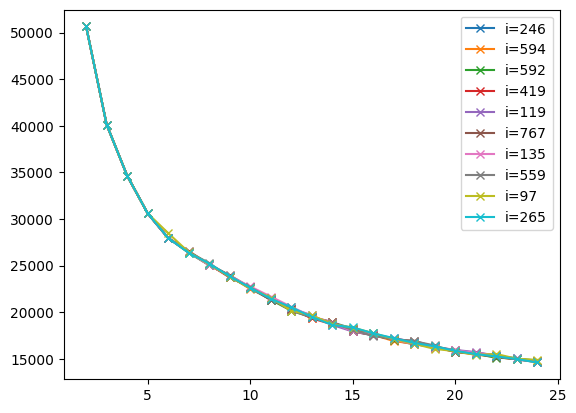

In [22]:
Functions.plot_inertia(scaled_data, 25, 10)

In [16]:
kmeans_solZ = KMeans(n_clusters=6, random_state=0).fit(scaled_data)
individuals['cluster_kmeansZ'] =  kmeans_solZ.predict(scaled_data)

In [17]:
Functions.compare_clusters(individuals, 'cluster_kmeansZ')

,0,1,2,3,4,5,general_mean
customer_gender,0.489873,0.502143,0.494143,0.499790,0.491567,0.500535,0.496574
kids_home,1.158017,0.277778,0.689588,0.997901,1.000203,3.075540,1.155404
teens_home,0.771308,0.218101,0.068547,0.271620,0.069904,1.809330,0.516827
number_complaints,0.311181,0.400923,0.500000,1.551008,1.010567,0.932377,0.770169
distinct_stores_visited,1.999578,2.330861,1.992625,7.999580,20.001829,3.007704,6.159636
lifetime_spend_groceries,996.823840,2873.138312,200.406291,14993.307935,302.959764,4999.391825,4008.813629
lifetime_spend_electronics,51.522574,605.672601,4999.557484,199.970403,20.000000,201.078108,972.556727
typical_hour,9.963291,17.213155,20.951844,11.914568,8.991668,17.403595,14.461107
lifetime_spend_vegetables,1495.537764,271.218595,20.033623,799.560034,300.231863,601.924674,568.474340
lifetime_spend_nonalcohol_drinks,20.985865,307.760303,1500.946855,900.786104,300.431823,900.171624,633.505206


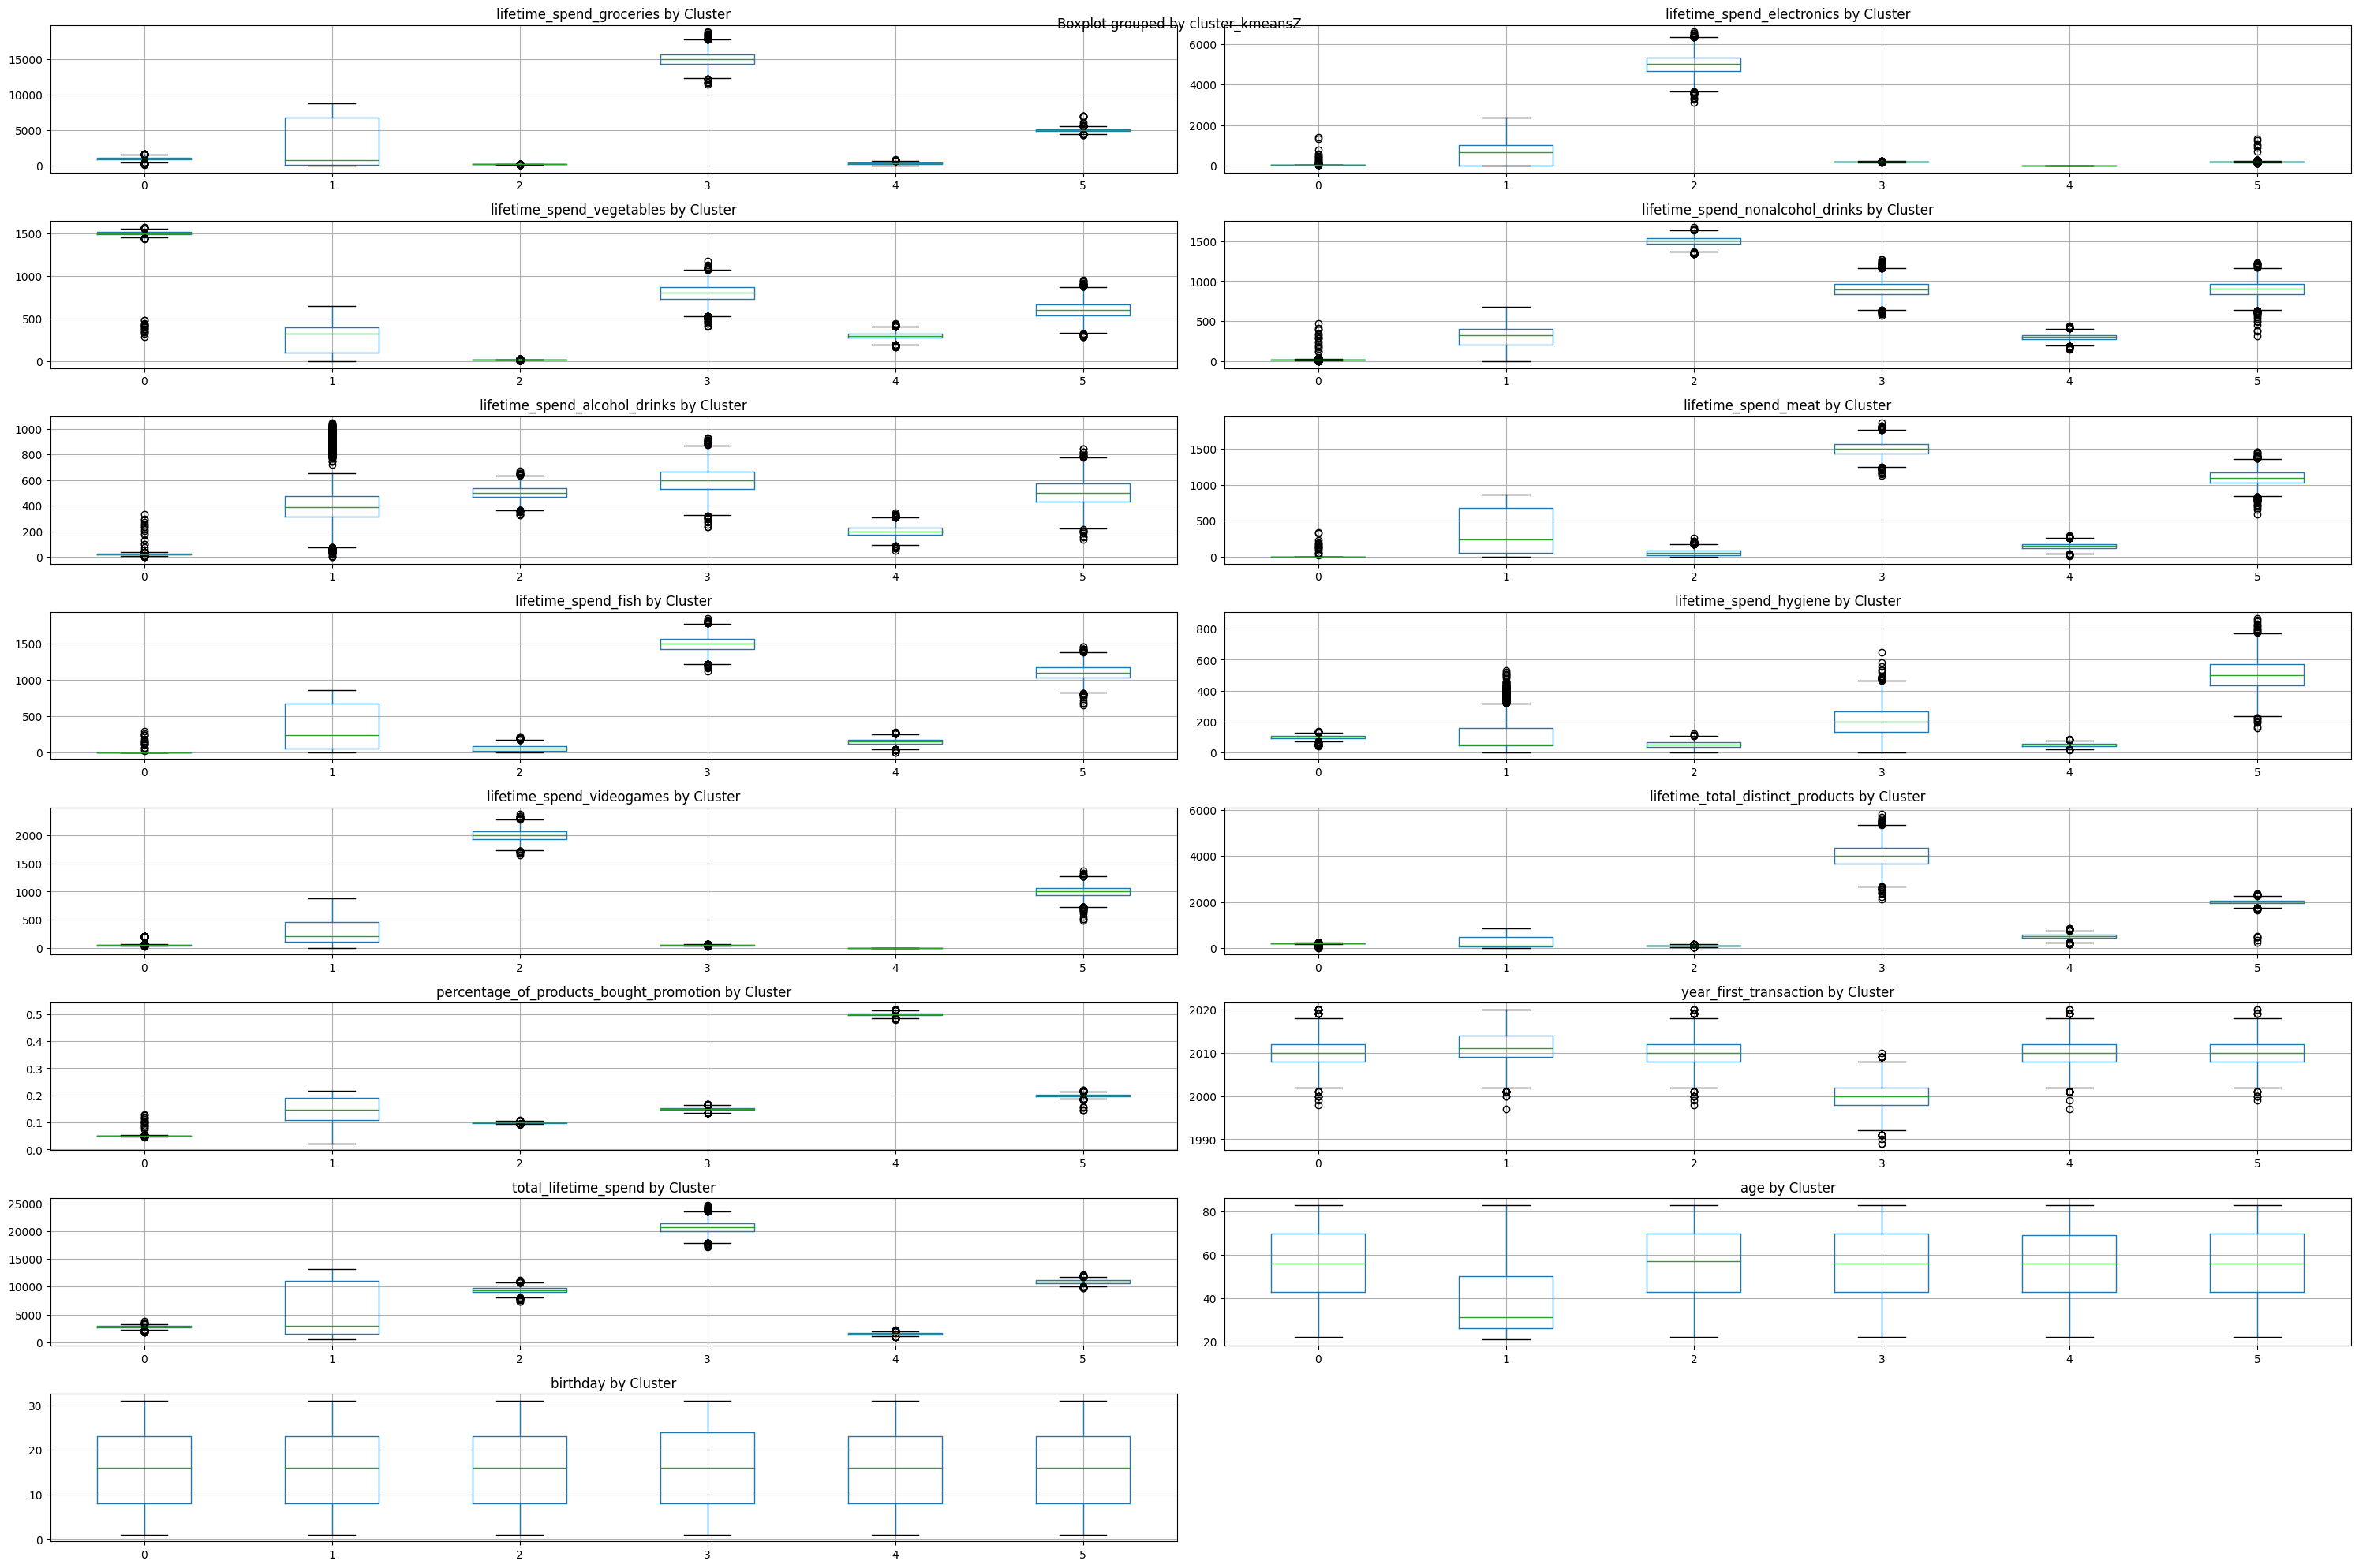

In [25]:
fig, axs = plt.subplots(12, 2, figsize=(30, 30))

    # Flatten the axs array for easy indexing
axs = axs.flatten()

for i, column in enumerate(continuous):
    ax = axs[i]
    individuals.boxplot(column=column, by='cluster_kmeansZ', ax=ax)
    ax.set_xlabel('')
    ax.set_title(column + ' by Cluster')

for i in range(len(axs)):
    if i >= len(continuous):
        axs[i].set_visible(False)

    # Adjust spacing between subplots
fig.tight_layout()

    # Show the plot
plt.show()

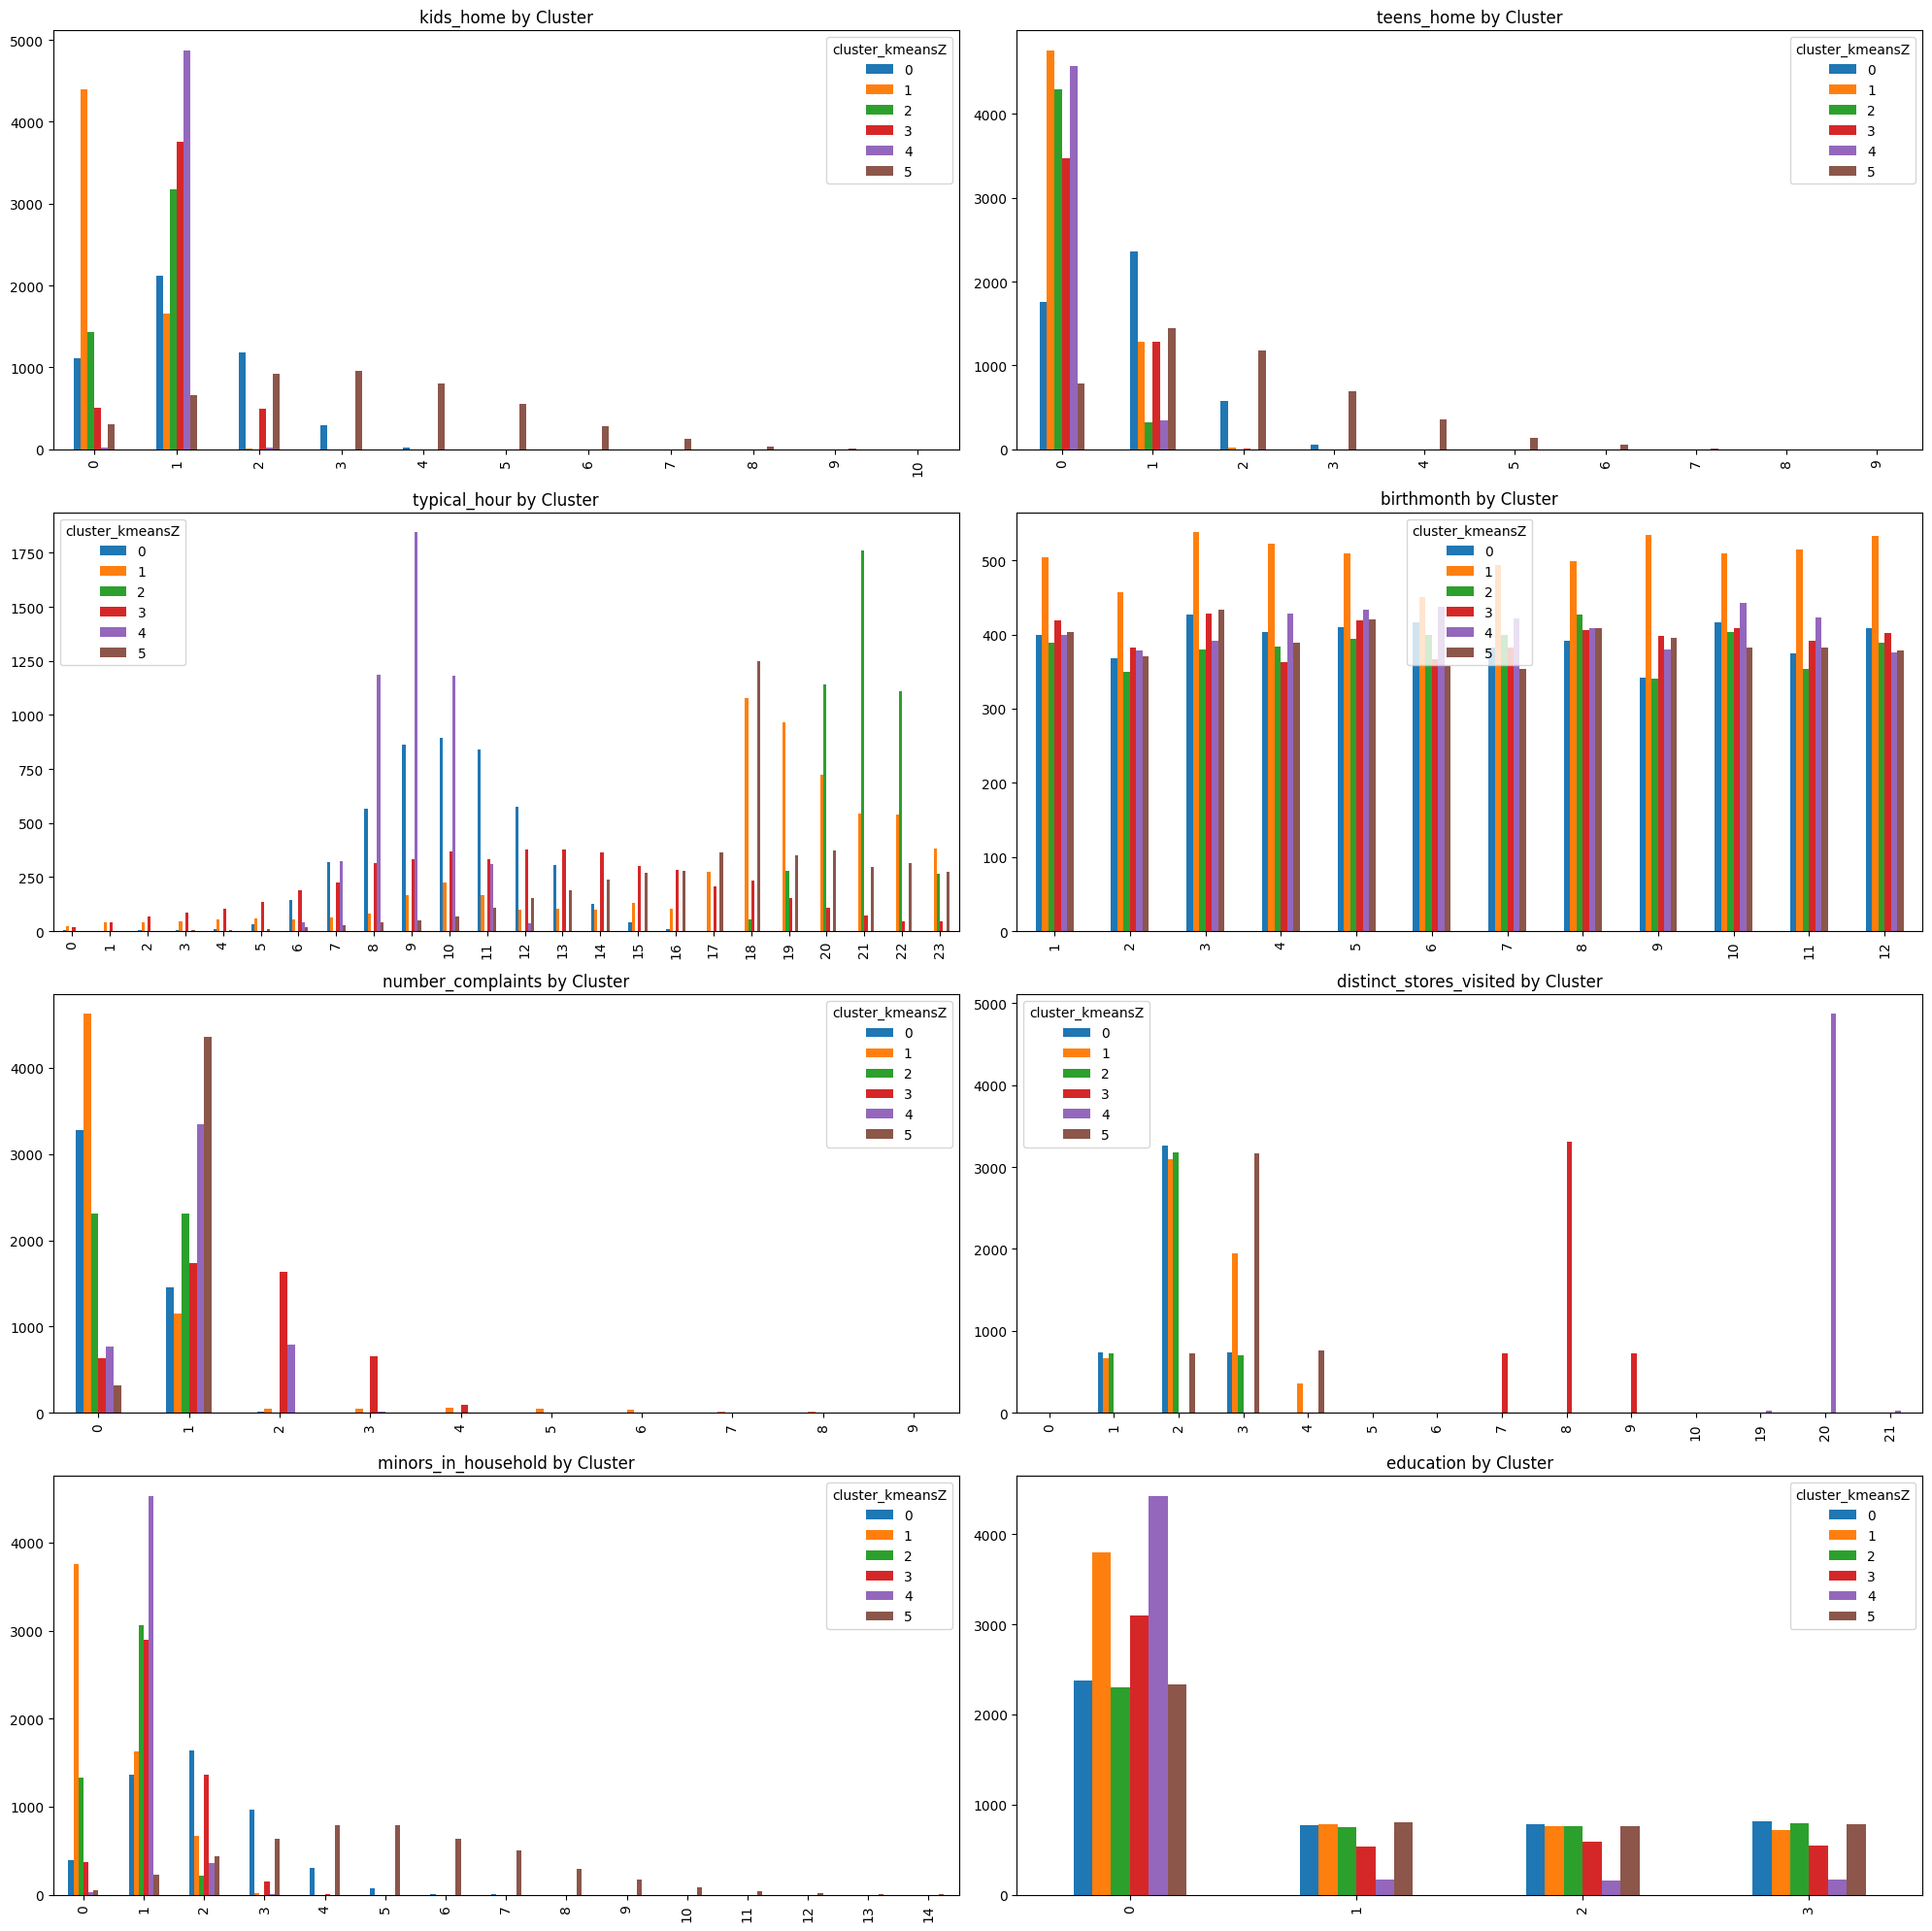

In [26]:
#HELP!!! PRECISO DE UMA ALTERNATIVA A ESTE PESSIMO GRAFICO
fig, axs = plt.subplots(4, 2, figsize=(20, 20))

    # Flatten the axs array for easy indexing
axs = axs.flatten()

for i, column in enumerate(discrete):
    ax = axs[i]
    individuals.groupby(column)['cluster_kmeansZ'].value_counts().unstack().plot(kind='bar', ax=ax)
    ax.set_xlabel('')
    ax.set_title(column + ' by Cluster')

for i in range(len(axs)):
    if i >= len(discrete):
        axs[i].set_visible(False)

    # Adjust spacing between subplots
fig.tight_layout()

    # Show the plot
plt.show()

In [ ]:
sns.pairplot(individuals[columns], hue = "cluster_kmeansZ", kind = 'scatter', diag_kind = 'hist', corner = True, plot_kws = dict(alpha = 0.4), diag_kws=dict(fill=False), size = 3, palette = colors)

KeyError: "['cluster_kmeans1'] not in index"

#### Confusion Matrices (ainda sem posição no indice)

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
pd.DataFrame(
    confusion_matrix(individuals.cluster_kmeans3, individuals.cluster_kmeansZ),
    index = ['K-Means 3rd Solution {} Cluster'.format(i) for i in np.arange(0,6)],
    columns = ['K-Means Z Solution {} Cluster'.format(i) for i in np.arange(0,6)],
)

,K-Means Z Solution 0 Cluster,K-Means Z Solution 1 Cluster,K-Means Z Solution 2 Cluster,K-Means Z Solution 3 Cluster,K-Means Z Solution 4 Cluster,K-Means Z Solution 5 Cluster
K-Means 3rd Solution 0 Cluster,0,0,0,1906,0,3267
K-Means 3rd Solution 1 Cluster,4731,9,0,0,0,0
K-Means 3rd Solution 2 Cluster,0,0,4610,0,0,0
K-Means 3rd Solution 3 Cluster,0,450,0,2858,0,1406
K-Means 3rd Solution 4 Cluster,9,5607,0,0,0,0
K-Means 3rd Solution 5 Cluster,0,0,0,0,4921,0


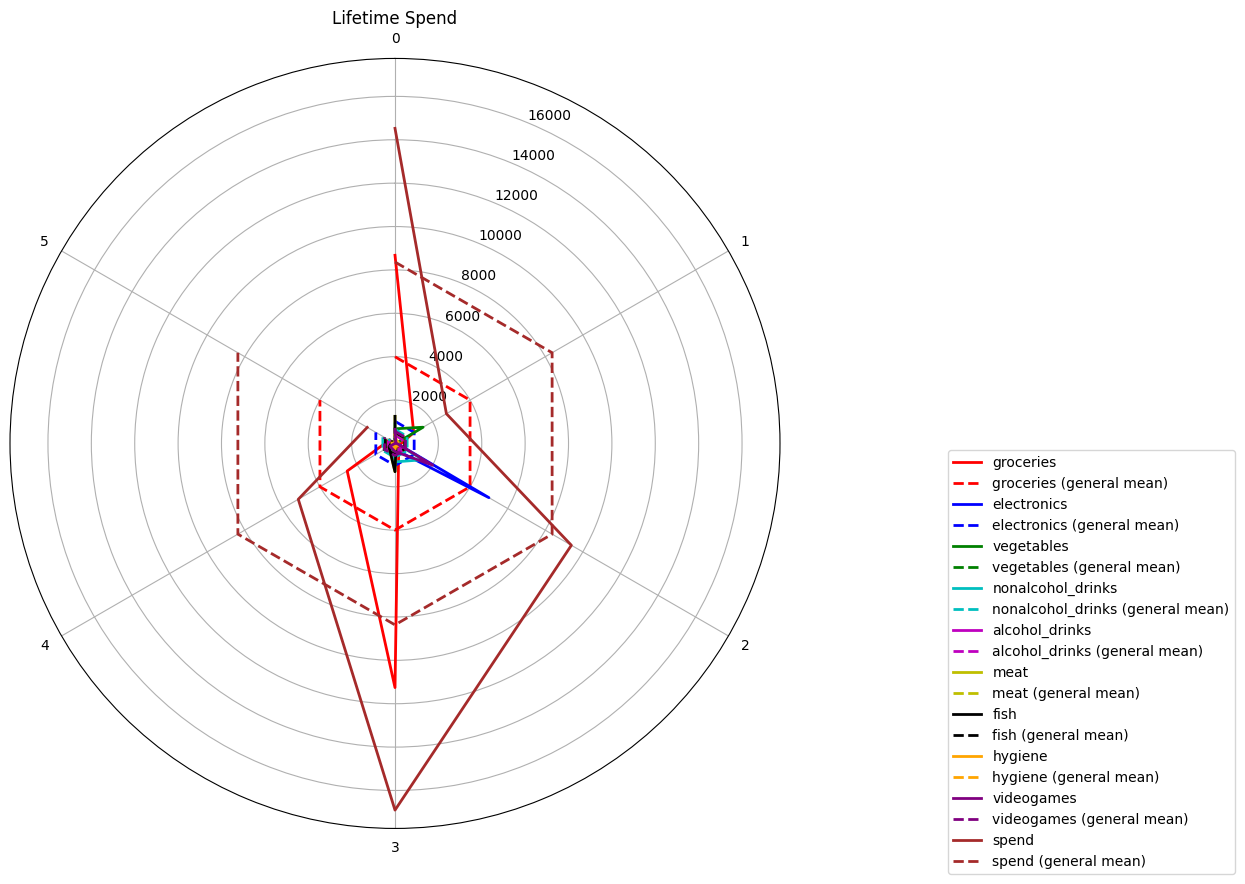

In [ ]:
#ATENÇÃO, PARTE DO CÓDIGO É DO CHATGPT

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10,10))

# Define column names
columns = ['lifetime_spend_groceries', 'lifetime_spend_electronics', 'lifetime_spend_vegetables', 'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks', 'lifetime_spend_meat', 'lifetime_spend_fish', 'lifetime_spend_hygiene', 'lifetime_spend_videogames', 'total_lifetime_spend']

# Define colors for each variable
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

for i, column in enumerate(columns):
    filter_data = individuals.groupby('cluster_kmeans3', as_index=False)[column].mean()
    color = colors[i % len(colors)]  # Get color for variable
    ax.plot(np.linspace(0, 2*np.pi, len(filter_data['cluster_kmeans3']), endpoint=False), 
          filter_data[column], color=color, linewidth=2)
    ax.plot(np.linspace(0, 2*np.pi, len(filter_data['cluster_kmeans3']), endpoint=False), 
    np.full_like(np.linspace(0, 2*np.pi, len(filter_data['cluster_kmeans3']), endpoint=False), filter_data[column].mean()) ,'--', color=color, linewidth=2)

# Set Theta to North
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

# Modify legend labels
legend_labels = []
for col in columns:
    legend_labels.append(col[15:])
    legend_labels.append(col[15:] + ' (general mean)')
plt.legend(legend_labels, bbox_to_anchor=(1.6, 0.5))

# Set X Ticks and title
ax.set_xticks(np.linspace(0, 2*np.pi, len(filter_data['cluster_kmeans3']), endpoint=False))
ax.set_xticklabels(filter_data['cluster_kmeans3'])
ax.set_title('Lifetime Spend')

#ax.set_rlim(0, 500)

plt.show()

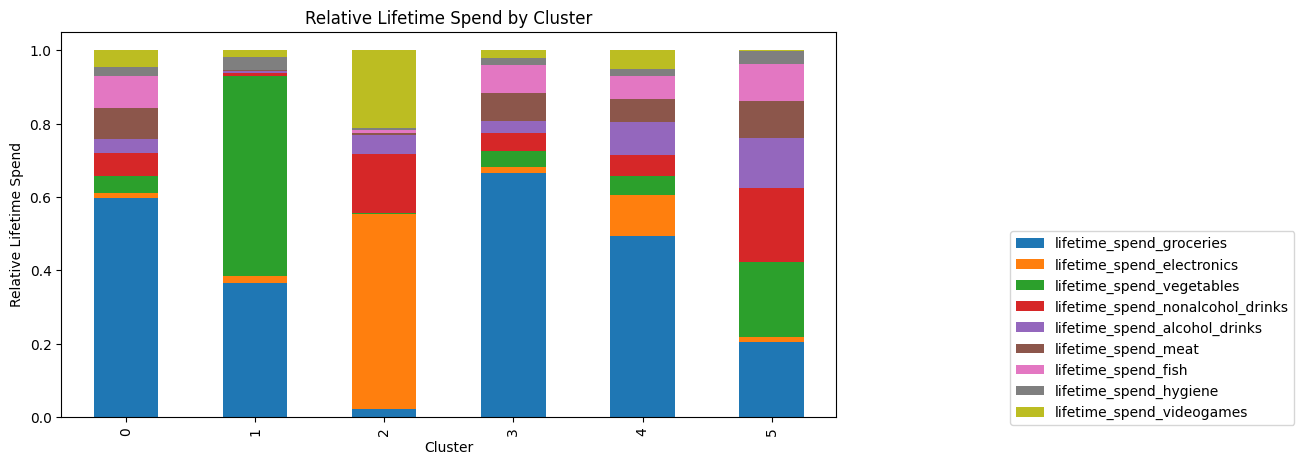

In [ ]:
#CHAT GPT
fig, axs = plt.subplots(1, 1, figsize=(10, 5), sharey=True)

columns2 = ['lifetime_spend_groceries', 'lifetime_spend_electronics', 'lifetime_spend_vegetables', 'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks', 'lifetime_spend_meat', 'lifetime_spend_fish', 'lifetime_spend_hygiene', 'lifetime_spend_videogames']

# Group the data by cluster and compute the mean of each category
data = individuals.groupby('cluster_kmeans3')[columns2].mean()

# Normalize the data by dividing each value in a row by the total value of that row
data = data.div(data.sum(axis=1), axis=0)

# Plot the relative stacked bar chart
data.plot(kind='bar', stacked=True, ax=axs)

# Add labels and titles
axs.set_xlabel('Cluster')
axs.set_ylabel('Relative Lifetime Spend')
axs.set_title('Relative Lifetime Spend by Cluster')
plt.legend(loc='upper right',bbox_to_anchor=(1.6, 0.5))
plt.show()

In [20]:
individuals

,customer_name,customer_gender,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,...,total_lifetime_spend,minors_in_household,birthday,birthmonth,age,education,lifetime_spend_animal_protein,lifetime_spend_technology,cluster_kmeans3,cluster_kmeansZ
customer_id,,,,,,,,,,,,,,,,,,,,,
4239,Sara Moscowitz,1,0,0,0,2,91.0,20.0,22,22.0,...,1545.0,0,10,9,24,0,101.0,125.0,4,1
19330,Donald Robertson,0,1,0,0,2,197.0,5958.0,21,20.0,...,10219.0,1,26,6,42,0,166.0,7922.0,2,2
2272,Felicia Bradshaw,1,1,1,0,20,397.0,20.0,9,310.0,...,1753.0,2,31,1,36,3,374.0,25.0,5,4
25288,Emma Williams,1,3,4,1,2,5282.0,237.0,12,499.0,...,11195.0,7,17,6,81,0,2149.0,1315.0,0,5
12829,Hilda Huerta,1,0,0,0,2,82.0,22.0,21,9.0,...,1370.0,0,31,1,23,0,78.0,125.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,Karen Watts,1,0,0,1,2,209.0,5474.0,20,18.0,...,9730.0,0,1,11,49,3,32.0,7458.0,2,2
26447,Curtis Thompson,0,0,0,0,3,185.0,1066.0,15,267.0,...,2416.0,0,21,2,37,0,88.0,1263.0,4,1
182,Richard Carter,0,0,0,0,2,83.0,23.0,23,23.0,...,1491.0,0,14,1,22,0,107.0,117.0,4,1


In [21]:
supermarkets = pd.read_csv('supermarkets preprocessed.csv')

In [22]:
individuals

,customer_name,customer_gender,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,...,total_lifetime_spend,minors_in_household,birthday,birthmonth,age,education,lifetime_spend_animal_protein,lifetime_spend_technology,cluster_kmeans3,cluster_kmeansZ
customer_id,,,,,,,,,,,,,,,,,,,,,
4239,Sara Moscowitz,1,0,0,0,2,91.0,20.0,22,22.0,...,1545.0,0,10,9,24,0,101.0,125.0,4,1
19330,Donald Robertson,0,1,0,0,2,197.0,5958.0,21,20.0,...,10219.0,1,26,6,42,0,166.0,7922.0,2,2
2272,Felicia Bradshaw,1,1,1,0,20,397.0,20.0,9,310.0,...,1753.0,2,31,1,36,3,374.0,25.0,5,4
25288,Emma Williams,1,3,4,1,2,5282.0,237.0,12,499.0,...,11195.0,7,17,6,81,0,2149.0,1315.0,0,5
12829,Hilda Huerta,1,0,0,0,2,82.0,22.0,21,9.0,...,1370.0,0,31,1,23,0,78.0,125.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,Karen Watts,1,0,0,1,2,209.0,5474.0,20,18.0,...,9730.0,0,1,11,49,3,32.0,7458.0,2,2
26447,Curtis Thompson,0,0,0,0,3,185.0,1066.0,15,267.0,...,2416.0,0,21,2,37,0,88.0,1263.0,4,1
182,Richard Carter,0,0,0,0,2,83.0,23.0,23,23.0,...,1491.0,0,14,1,22,0,107.0,117.0,4,1


In [23]:
supermarkets['cluster_kmeansZ'] = 6

In [24]:
supermarkets['cluster_kmeans3'] = 6

In [25]:
supermarkets.set_index('customer_id', inplace=True)

In [26]:
customers = pd.concat([individuals, supermarkets], axis=0)

In [27]:
customers

,customer_name,customer_gender,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,...,total_lifetime_spend,minors_in_household,birthday,birthmonth,age,education,lifetime_spend_animal_protein,lifetime_spend_technology,cluster_kmeans3,cluster_kmeansZ
customer_id,,,,,,,,,,,,,,,,,,,,,
4239,Sara Moscowitz,1.0,0.0,0.0,0.0,2.0,91.0,20.0,22.0,22.0,...,1545.0,0.0,10.0,9.0,24.0,0.0,101.0,125.0,4,1
19330,Donald Robertson,0.0,1.0,0.0,0.0,2.0,197.0,5958.0,21.0,20.0,...,10219.0,1.0,26.0,6.0,42.0,0.0,166.0,7922.0,2,2
2272,Felicia Bradshaw,1.0,1.0,1.0,0.0,20.0,397.0,20.0,9.0,310.0,...,1753.0,2.0,31.0,1.0,36.0,3.0,374.0,25.0,5,4
25288,Emma Williams,1.0,3.0,4.0,1.0,2.0,5282.0,237.0,12.0,499.0,...,11195.0,7.0,17.0,6.0,81.0,0.0,2149.0,1315.0,0,5
12829,Hilda Huerta,1.0,0.0,0.0,0.0,2.0,82.0,22.0,21.0,9.0,...,1370.0,0.0,31.0,1.0,23.0,0.0,78.0,125.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4689,Justin`s Supermarket,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,6
16270,Melissa`s Supermarket,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,6
10262,Francis`s Supermarket,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,6


In [28]:
customers.to_csv('customers_clustered.csv', index=True)

In [20]:
pip install umap-learn 

     |████████████████████████████████| 88 kB 5.3 MB/s eta 0:00:011
     |████████████████████████████████| 2.5 MB 17.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 29.4 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 8.1 MB/s  eta 0:00:01
     |████████████████████████████████| 30.4 MB 5.3 MB/s eta 0:00:011
Using legacy 'setup.py install' for umap-learn, since package 'wheel' is not installed.
Using legacy 'setup.py install' for pynndescent, since package 'wheel' is not installed.
    Running setup.py install for pynndescent ... done
    Running setup.py install for umap-learn ... done
You should consider upgrading via the '/usr/local/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [29]:
# Umap library
import umap

# Matplotlib Options
plt.rcParams['figure.figsize'] = [16, 8]
font = {'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)

In [53]:
columns_to_drop = ['cluster_kmeans3', 'customer_name', 'region']
data_Z = individuals.drop(columns_to_drop, axis=1)

# Assuming your k-means cluster solutions are stored in 'individuals'
labels_Z = individuals['cluster_kmeansZ'].values

In [54]:
reducer = umap.UMAP()
embedding_Z = reducer.fit_transform(data_Z)

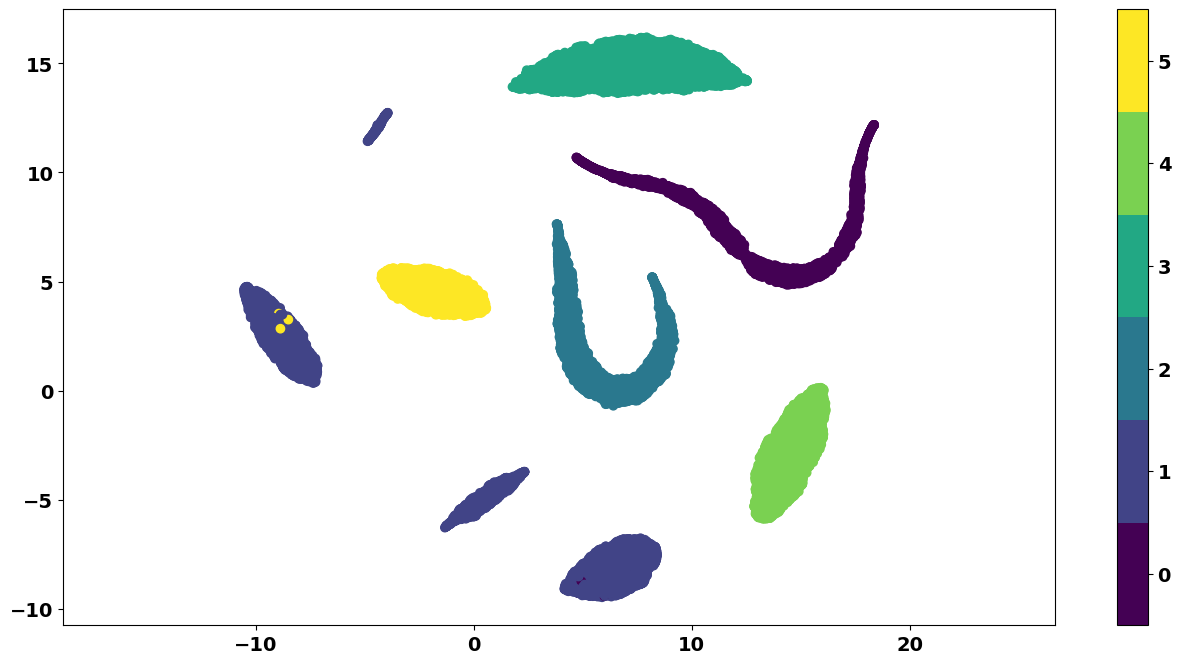

In [55]:
plt.scatter(embedding_Z[:, 0], embedding_Z[:, 1], c=labels_Z, cmap='viridis')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(7)-0.5).set_ticks(np.arange(6))
plt.show()

In [56]:
data_3 = individuals.drop(columns_to_drop, axis=1)

# Assuming your k-means cluster solutions are stored in 'individuals'
labels_3 = individuals['cluster_kmeans3'].values

In [57]:
embedding_3 = reducer.fit_transform(data_3)

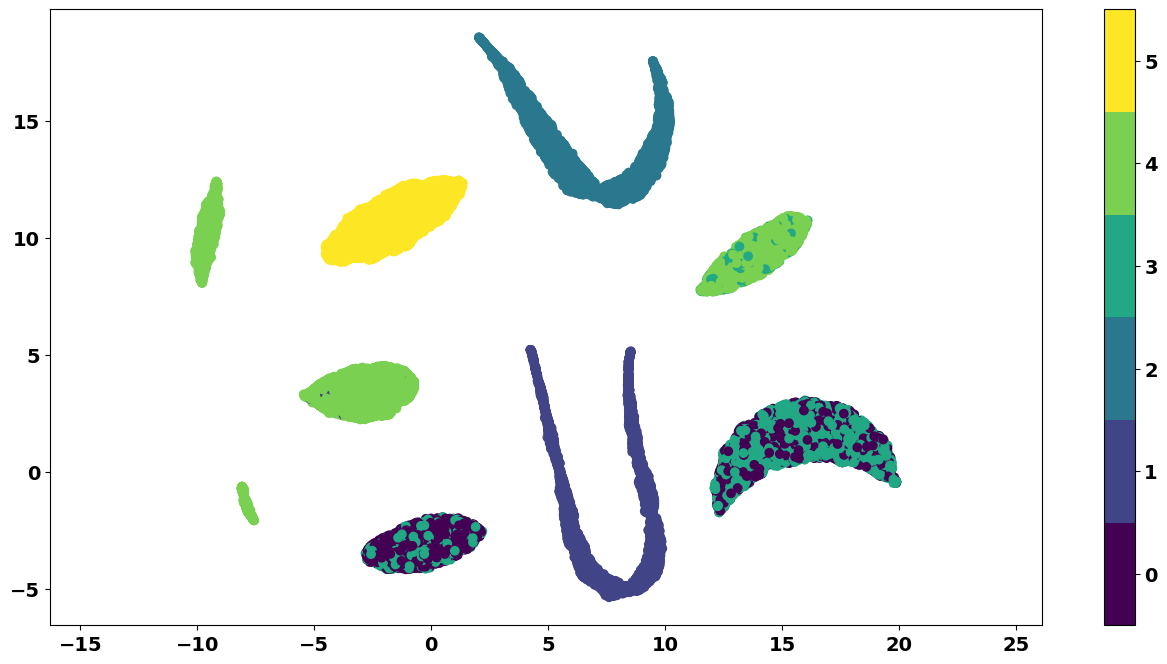

In [60]:
plt.scatter(embedding_3[:, 0], embedding_3[:, 1], c=labels_3, cmap='viridis')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(7)-0.5).set_ticks(np.arange(6))
plt.show()